In [1]:
import os
import boto3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import itertools

from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from mlflow.models.signature import infer_signature

### 1. Fetching and loading dataset

In [2]:

load_dotenv()
BUCKET_NAME = "staywise-data"
S3_PREFIX   = "raw_data/"
LOCAL_DIR   = "data/raw_data" 
s3 = boto3.resource("s3")


def download_s3_files(bucket_name: str, prefix: str, local_dir: str) -> None:
    bucket = s3.Bucket(bucket_name)

    for obj in bucket.objects.filter(Prefix=prefix):
        key = obj.key
        if key.endswith('/'):
            continue
        rel_path = key[len(prefix):]
        local_path = os.path.join(local_dir, rel_path)
        os.makedirs(os.path.dirname(local_path), exist_ok=True)

        # Download the file
        bucket.download_file(key, local_path)
        print(f"Downloaded s3://{bucket_name}/{key} -> {local_path}")

download_s3_files(BUCKET_NAME, S3_PREFIX, LOCAL_DIR)

Downloaded s3://staywise-data/raw_data/AB_NYC_2019.csv -> data/raw_data/AB_NYC_2019.csv
Downloaded s3://staywise-data/raw_data/Ab Nyc2019 Data Dictionary.docx -> data/raw_data/Ab Nyc2019 Data Dictionary.docx
Downloaded s3://staywise-data/raw_data/Ab Nyc2019 Data Dictionary.docx -> data/raw_data/Ab Nyc2019 Data Dictionary.docx


In [3]:
import glob

csv_files = glob.glob(os.path.join(LOCAL_DIR, "*.csv"))

if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {LOCAL_DIR}. Please check S3 download.")

# Use the first CSV found
dataset_path = csv_files[0]
print(f"Loading dataset from: {dataset_path}")

data = pd.read_csv(dataset_path)
data.head()

Loading dataset from: data/raw_data/AB_NYC_2019.csv


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
# Data Overview
print("Dataset Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())
print("\nDescriptive Statistics:")
data.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review       

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


### 2. Data Cleaning and Preprocessing

In [5]:
# Making a copy for cleaning
df = data.copy()

# Drop irrelevant columns
cols_to_drop = ['id', 'name', 'host_name', 'last_review']
df = df.drop(columns=cols_to_drop)

# Handle missing values
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

# Check if any missing values remain
print("Missing values after cleaning:")
print(df.isnull().sum())

Missing values after cleaning:
host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64
host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64


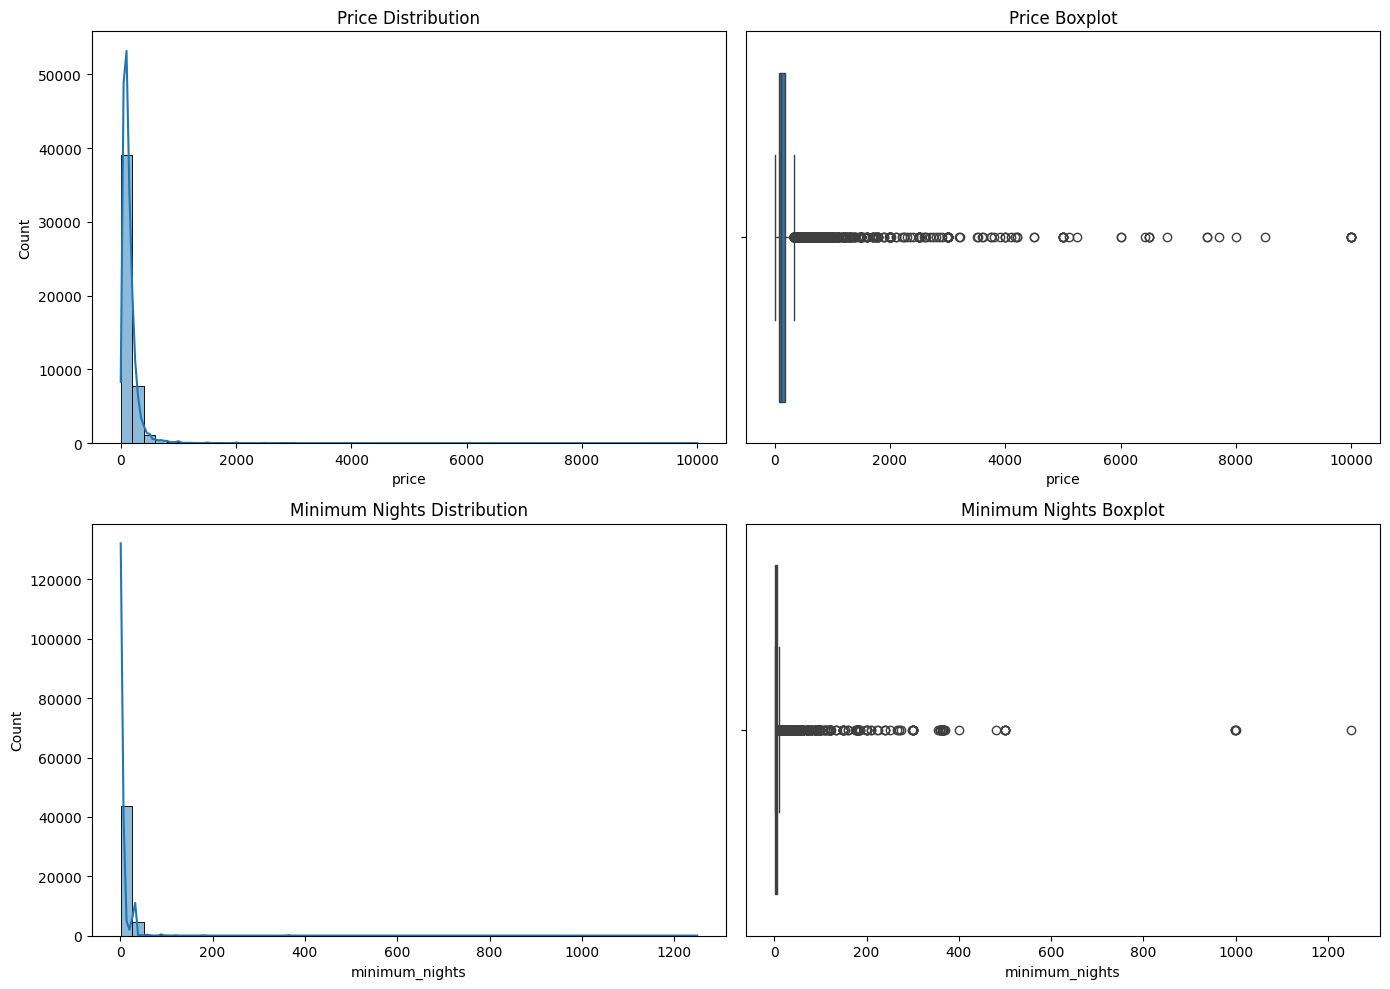

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Price Distribution
sns.histplot(df['price'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Price Distribution')

# Price Boxplot
sns.boxplot(x=df['price'], ax=axes[0, 1])
axes[0, 1].set_title('Price Boxplot')

# Minimum Nights Distribution
sns.histplot(df['minimum_nights'], bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Minimum Nights Distribution')

# Minimum Nights Boxplot
sns.boxplot(x=df['minimum_nights'], ax=axes[1, 1])
axes[1, 1].set_title('Minimum Nights Boxplot')

plt.tight_layout()
plt.show()

In [7]:
# Outlier Handling

init_rows = df.shape[0]

# Cap price at the $2000 to reduce skewness
df = df[df['price'] <= 2000]

# Cap at 365 days
df = df[df['minimum_nights'] <= 365]

print(f"Data shape after outlier removal: {df.shape}, {init_rows - df.shape[0]} invalid records removed")

Data shape after outlier removal: (48795, 12), 100 invalid records removed


In [8]:
# Categorical Encoding
# 'neighbourhood_group' and 'room_type' -> One-Hot Encoding
# 'neighbourhood' -> Frequency Encoding (high cardinality)

# Frequency encoding for neighbourhood
neighbourhood_freq = df['neighbourhood'].value_counts(normalize=True)
df['neighbourhood_freq'] = df['neighbourhood'].map(neighbourhood_freq)

# One-Hot Encoding for others
df = pd.get_dummies(df, columns=['neighbourhood_group', 'room_type'], prefix=['grp', 'room'], drop_first=True)

print("Processed Data Head:")
df.head()

Processed Data Head:


,host_id,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_freq,grp_Brooklyn,grp_Manhattan,grp_Queens,grp_Staten Island,room_Private room,room_Shared room
0,2787,Kensington,40.64749,-73.97237,149,1,9,0.21,6,365,0.003566,True,False,False,False,True,False
1,2845,Midtown,40.75362,-73.98377,225,1,45,0.38,2,355,0.031602,False,True,False,False,False,False
2,4632,Harlem,40.80902,-73.94190,150,3,0,0.00,1,365,0.054370,False,True,False,False,True,False
3,4869,Clinton Hill,40.68514,-73.95976,89,1,270,4.64,1,194,0.011661,True,False,False,False,False,False
4,7192,East Harlem,40.79851,-73.94399,80,10,9,0.10,1,0,0.022871,False,True,False,False,False,False


# Model Development
* Split the data into training and testing sets, and then train multiple regression models.
* Use **MLflow** to track my experiments, logging metrics like RMSE, MAE, and R2 score.

In [9]:
# Prepare Data
# Drop 'neighbourhood' (original string column) and 'host_id' (high cardinality)
if 'neighbourhood' in df.columns:
    df = df.drop(columns=['neighbourhood'])
if 'host_id' in df.columns:
    df = df.drop(columns=['host_id'])

# Define features (X) and target (y)
X = df.drop(columns=['price'])
y = df['price']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (39036, 14)
Testing shape: (9759, 14)


In [10]:
def log_mlflow_run(rmse, mae, r2, predictions, model, model_type, params=None):
    # Log Params & Metrics
    if(params):
        mlflow.log_params(params)
    mlflow.log_param("model_type", model_type)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    
    # Log Model
    input_example = X_train.iloc[:5].astype(float)
    signature = infer_signature(input_example, predictions)
    
    mlflow.sklearn.log_model(
        sk_model=model, 
        name="model",
        signature=signature,
        input_example=input_example,
    )

In [11]:
# MLflow Experiment Setup
mlflow.set_experiment("Staywise_Price_Prediction")

def train_and_evaluate(model, model_name, model_type):
    with mlflow.start_run(run_name=model_name):
        # Train
        model.fit(X_train, y_train)
        
        # Predict
        predictions = model.predict(X_test)
        
        # Metrics
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        
        print(f"--- {model_name} ---")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"R2: {r2:.2f}")
        
        # Log to MLflow
        log_mlflow_run(rmse, mae, r2, predictions, model, model_type)

print("MLflow setup complete.")

/home/ryan/venv/lib/python3.12/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
2025/11/21 12:20:32 INFO mlflow.tracking.fluent: Experiment with name 'Staywise_Price_Prediction' does not exist. Creating a new experiment.


MLflow setup complete.


In [12]:
# Train and evaluate models

lr = LinearRegression()
train_and_evaluate(lr, "Linear_Regression", "LinearRegression")

rf = RandomForestRegressor(n_estimators=50, random_state=42)
train_and_evaluate(rf, "Random_Forest", "RandomForestRegressor")

--- Linear_Regression ---
RMSE: 118.50
MAE: 62.32
R2: 0.26
--- Random_Forest ---
RMSE: 112.96
MAE: 55.63
R2: 0.32
--- Random_Forest ---
RMSE: 112.96
MAE: 55.63
R2: 0.32


# Hyperparameter Tuning
I have performed a grid search over hyperparameters for the Random Forest model to find the optimal configuration.
Each combination will be logged as a separate run in MLflow.

In [14]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Generate all combinations
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Starting hyperparameter tuning with {len(param_combinations)} combinations...")

for i, params in enumerate(param_combinations):
    run_name = f"RF_Tuning_{i+1}"
    
    with mlflow.start_run(run_name=run_name):
        # Create model with current params
        rf = RandomForestRegressor(random_state=42, **params)
        
        # Train
        rf.fit(X_train, y_train)
        
        # Predict
        predictions = rf.predict(X_test)
        
        # Metrics
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        
        log_mlflow_run(rmse, mae, r2, predictions, rf, "RandomForestRegressor", params)
        
        print(f"Run {i+1}/{len(param_combinations)} - Params: {params} - RMSE: {rmse:.2f}")

Starting hyperparameter tuning with 27 combinations...
Run 1/27 - Params: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2} - RMSE: 111.66
Run 1/27 - Params: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2} - RMSE: 111.66
Run 2/27 - Params: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5} - RMSE: 111.61
Run 2/27 - Params: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5} - RMSE: 111.61
Run 3/27 - Params: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 10} - RMSE: 111.87
Run 3/27 - Params: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 10} - RMSE: 111.87
Run 4/27 - Params: {'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 2} - RMSE: 112.79
Run 4/27 - Params: {'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 2} - RMSE: 112.79
Run 5/27 - Params: {'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 5} - RMSE: 111.87
Run 5/27 - Params: {'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 5

# Hyperparameter Tuning for Linear Regression
I have also tried tuning the Linear Regression model by experimenting with `fit_intercept` and `positive` constraints.

In [15]:
X_train_tune = X_train
y_train_tune = y_train
X_test_tune = X_test
y_test_tune = y_test

param_grid_lr = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Generate all combinations
keys_lr, values_lr = zip(*param_grid_lr.items())
param_combinations_lr = [dict(zip(keys_lr, v)) for v in itertools.product(*values_lr)]

print(f"Starting hyperparameter tuning for Linear Regression with {len(param_combinations_lr)} combinations...")

for i, params in enumerate(param_combinations_lr):
    run_name = f"LR_Tuning_{i+1}"
    
    with mlflow.start_run(run_name=run_name):
        lr = LinearRegression(**params)
        
        # Train
        lr.fit(X_train_tune, y_train_tune)
        
        # Predict
        predictions = lr.predict(X_test_tune)
        
        preds_actual = predictions
        y_test_actual = y_test_tune
            
        # Metrics
        rmse = np.sqrt(mean_squared_error(y_test_actual, preds_actual))
        mae = mean_absolute_error(y_test_actual, preds_actual)
        r2 = r2_score(y_test_actual, preds_actual)
        
        # Log Params & Metrics
        log_mlflow_run(rmse, mae, r2, predictions, lr, "LinearRegression", params)
        
        print(f"Run {i+1}/{len(param_combinations_lr)} - Params: {params} - RMSE: {rmse:.2f}")

Starting hyperparameter tuning for Linear Regression with 4 combinations...
Run 1/4 - Params: {'fit_intercept': True, 'positive': True} - RMSE: 131.05
Run 1/4 - Params: {'fit_intercept': True, 'positive': True} - RMSE: 131.05
Run 2/4 - Params: {'fit_intercept': True, 'positive': False} - RMSE: 118.50
Run 2/4 - Params: {'fit_intercept': True, 'positive': False} - RMSE: 118.50
Run 3/4 - Params: {'fit_intercept': False, 'positive': True} - RMSE: 131.05
Run 3/4 - Params: {'fit_intercept': False, 'positive': True} - RMSE: 131.05
Run 4/4 - Params: {'fit_intercept': False, 'positive': False} - RMSE: 118.78
Run 4/4 - Params: {'fit_intercept': False, 'positive': False} - RMSE: 118.78


# Best Model Selection
Retrieve all runs from the experiment and identify the model with the lowest RMSE.

In [16]:
# Search all runs in the experiment
current_experiment = mlflow.get_experiment_by_name("Staywise_Price_Prediction")
runs = mlflow.search_runs(experiment_ids=[current_experiment.experiment_id])

# Sort by RMSE (ascending) and drop any failed runs with rmse NAN to find the best model
best_run = runs.dropna(subset=['metrics.rmse']).sort_values("metrics.rmse").iloc[0]

print(f"Best Run ID: {best_run.run_id}")
print(f"Best RMSE: {best_run['metrics.rmse']:.4f}")
print("Best Parameters:")
for col in best_run.index:
    if col.startswith("params."):
        print(f"  {col.split('.')[-1]}: {best_run[col]}")

# Register the best model
model_uri = f"runs:/{best_run.run_id}/model"
mlflow.register_model(model_uri, "Staywise_Best_Model")

Best Run ID: d8f3da80b85b40f1ac8afa415d116597
Best RMSE: 110.7133
Best Parameters:
  model_type: RandomForestRegressor
  fit_intercept: None
  positive: None
  max_depth: 20
  n_estimators: 200
  min_samples_split: 10


/home/ryan/venv/lib/python3.12/site-packages/mlflow/tracking/_model_registry/utils.py:215: FutureWarning: Filesystem model registry backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri)
Successfully registered model 'Staywise_Best_Model'.
2025/11/21 12:31:55 WARNING mlflow.tracking._model_registry.fluent: Run with id d8f3da80b85b40f1ac8afa415d116597 has no artifacts at artifact path 'model', registering model based on models:/m-9098f2d27d644c9baf3390a7baecc755 instead
Created version '1' of model 'Staywise_Best_Model'.
Created version '1' of model 'Staywise_Best_Model'.


<ModelVersion: aliases=[], creation_timestamp=1763746315609, current_stage='None', deployment_job_state=None, description=None, last_updated_timestamp=1763746315609, metrics=[<Metric: dataset_digest=None, dataset_name=None, key='mae', model_id='m-9098f2d27d644c9baf3390a7baecc755', run_id='d8f3da80b85b40f1ac8afa415d116597', step=0, timestamp=1763746160762, value=54.34931349499072>,
 <Metric: dataset_digest=None, dataset_name=None, key='r2', model_id='m-9098f2d27d644c9baf3390a7baecc755', run_id='d8f3da80b85b40f1ac8afa415d116597', step=0, timestamp=1763746160763, value=0.3506353699847671>,
 <Metric: dataset_digest=None, dataset_name=None, key='rmse', model_id='m-9098f2d27d644c9baf3390a7baecc755', run_id='d8f3da80b85b40f1ac8afa415d116597', step=0, timestamp=1763746160760, value=110.71326970554908>], model_id='m-9098f2d27d644c9baf3390a7baecc755', name='Staywise_Best_Model', params={'max_depth': '20',
 'min_samples_split': '10',
 'model_type': 'RandomForestRegressor',
 'n_estimators': '200'}

/home/ryan/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm





Top 10 Important Features:
                           Feature  Importance
1                        longitude    0.217444
12               room_Private room    0.194919
0                         latitude    0.167640
6                 availability_365    0.116043
2                   minimum_nights    0.071899
4                reviews_per_month    0.060243
3                number_of_reviews    0.050665
5   calculated_host_listings_count    0.049662
7               neighbourhood_freq    0.042080
13                room_Shared room    0.024152


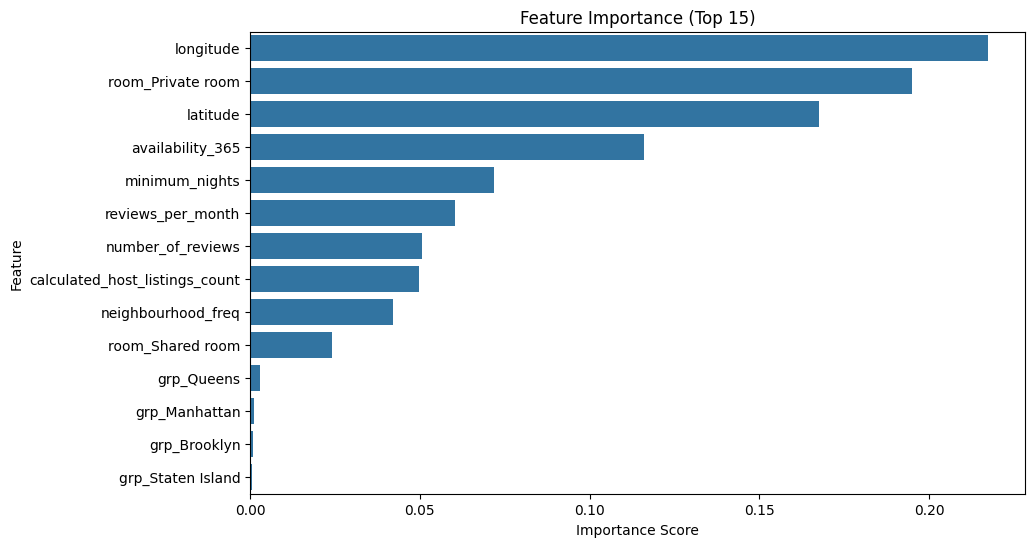

In [17]:
# --- Feature Importance Analysis ---
# Load the best model
loaded_model = mlflow.sklearn.load_model(model_uri)

# Check if the model supports feature importance (e.g. Random Forest)
if hasattr(loaded_model, 'feature_importances_'):
    importances = loaded_model.feature_importances_
    feature_names = X_train.columns
    
    # Create a DataFrame
    feature_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    print("\nTop 10 Important Features:")
    print(feature_imp_df.head(10))
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(15))
    plt.title('Feature Importance (Top 15)')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()
else:
    print("The selected model does not support feature importance (e.g., Linear Regression).")